In [1]:
from __future__ import print_function, division
from future import standard_library
standard_library.install_aliases()
import time
import os
import platform
from six.moves import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Auxiliary functions:

In [2]:
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x)  # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h)  # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext()  # step to next dimension

    return grad

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numerical gradient for a function that accepts a numpy array and returns a numpy array.
    df - derivative of the upstream function (chain rule)
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

# Load CIFAR dataset

In [4]:
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_%d" % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y
    
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == "2":
        return pickle.load(f)
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")
    raise ValueError("invalid python version: {}".format(version))

In [5]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, subtract_mean=True):
    
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare it for classifiers.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs/datasets/cifar-10-batches-py' #path to the data on your computer
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
    }

In [6]:
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Forward and Backward Passes of Modular Two Layers Neural Network

In [7]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    
    x_raw = x.reshape(x.shape[0], -1) #shape (N, D)
    out = x_raw@w + b #shape (N, M)

    cache = (x, w, b)
    return out, cache

In [14]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache

    x_raw = x.reshape(x.shape[0], -1) #shape (N, D)
    dw = x_raw.T@dout
    db = np.sum(dout, axis=0)
    dx = (dout@w.T).reshape(x.shape)
    
    return dx, dw, db

In [31]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))
print('dx error: ', rel_error(dx_num, dx))

Testing affine_backward function:
dw error:  2.1752492052093605e-10
db error:  1.8810031119556898e-11
dx error:  1.0908199508708189e-10


In [32]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = np.maximum(0, x)
    
    cache = x
    return out, cache

In [34]:
# Test the relu_forward function
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


In [35]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    dx = dout*(x > 0)
    
    return dx

In [49]:
# Test the relu_backward function
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


# "Sandwich" layers

In [50]:
def affine_relu_forward(x, w, b):
    """
    Convenience layer that performs an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache

def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db

In [51]:
# Test the affine_relu_backward function
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.750562121603446e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss: SVM and Softmax

In [62]:
def svm_loss(x, y):
    """
    Computes the loss and gradient for multiclass SVM classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and 0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    
    num_train = x.shape[0]
    scores = x
    correct_class_score = np.take_along_axis(scores, y[:, np.newaxis], axis=1) #shape: (N, 1)
    margin = scores - correct_class_score + 1 #shape (N, C)
    rows = np.arange(num_train)
    margin[rows, y] = 0
    margin[margin<0] = 0
    loss = np.sum(margin)/num_train

    misses = margin[:] #initialize matrix to store information about misclassified examples 
    misses[misses>0] = 1 #shape (N, C)
    num_misses = np.sum(misses, axis = 1, keepdims = True) #shape (N, 1); N[i] represent number of misscored classes for example i
    y_onehot = np.zeros((num_train, scores.shape[1])) #initialize onehot encoding; shape (N, C)
    y_onehot[rows, y] = 1 #one hot encoding
    y_onehot_times = y_onehot*num_misses # shape (N, C); for each example i, i was misscored ( y_onehot_times[i, yi] ) times; rest of matrix is zero
    dx = misses - y_onehot_times
    dx /= num_train

    return loss, dx

def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and 0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    num_train = x.shape[0]
    fs = x     
    fs = fs - fs.max(axis = 1, keepdims = True) #exponents that are numerically stable
    probs = np.exp(fs)/np.sum(np.exp(fs), axis = 1, keepdims = True) #probabilities
    loss = -np.sum(np.log(probs[range(num_train), y]))
    loss = loss/num_train

    probs[range(num_train), y] -= 1
    dx = probs/num_train

    return loss, dx

In [71]:
#testing loss implementation
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  9.00001750786739
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.3025873213457944
dx error:  7.528259945478461e-09


# Two-layer network

In [97]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3 * 32 * 32, hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random initialization of the weights
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        W1 = np.random.randn(input_dim, hidden_dim)*weight_scale
        b1 = np.zeros(hidden_dim)
        W2 = np.random.randn(hidden_dim, num_classes)*weight_scale
        b2 = np.zeros(num_classes)

        self.params["W1"] = W1
        self.params["b1"] = b1
        self.params["W2"] = W2
        self.params["b2"] = b2

    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """

        A1, cache = affine_relu_forward(X, self.params["W1"], self.params["b1"])
        scores, cache_sc = affine_forward(A1, self.params["W2"], self.params["b2"])

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}

        loss, dsoft = softmax_loss(scores, y)
        loss += 0.5*self.reg*(np.sum(self.params["W1"]**2) + np.sum(self.params["W2"]**2))

        dx1, dW2, db2 = affine_backward(dsoft, cache_sc)
        dx0, dW1, db1 = affine_relu_backward(dx1, cache)
        dW2 += 0.5*2*self.reg*(self.params["W2"])               #0.5 to simplify the expression for the gradient
        dW1 += 0.5*2*self.reg*(self.params["W1"])               #0.5 to simplify the expression for the gradient

        grads["W2"] = dW2
        grads["b2"] = db2
        grads["W1"] = dW1
        grads["b1"] = db1

        return loss, grads

### update rule: stochastic gradient descent

In [101]:
def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)

    w -= config["learning_rate"] * dw
    
    return w, config

# Training

In [102]:
class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent defined in sgd.

    The solver accepts both training and validation data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, we first construct a Solver instance, passing the
    model, dataset, and various options (learning rate, batch size, etc) to the
    constructor. We will then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists of the
    accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = {
      'X_train': # training data
      'y_train': # training labels
      'X_val': # validation data
      'y_val': # validation labels
    }
    model = MyModel(hidden_size=100, reg=10)
    solver = Solver(model, data, update_rule='sgd', optim_config={'learning_rate': 1e-4}, lr_decay=0.95,
                    num_epochs=5, batch_size=200, print_every=100)
    solver.train()

    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and
      return a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val': Array, shape (N_val,) of labels for validation images

        Optional arguments:
        - update_rule: A string giving the name of an update rule. Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters but all update rules require a
          'learning_rate' parameter so that should always be present.
          In this notebook we will use "sgd" update rule only.
        - lr_decay: A scalar for learning rate decay; after each epoch the
          learning rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient
          during training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every
          print_every iterations.
        - verbose: Boolean; if set to false then no output will be printed
          during training.
        - num_train_samples: Number of training samples used to check training
          accuracy; default is 1000; set to None to use entire training set.
        - num_val_samples: Number of validation samples to use to check val
          accuracy; default is None, which uses the entire validation set.
        - checkpoint_name: If not None, then save model checkpoints here every
          epoch.
        """
        self.model = model
        self.X_train = data["X_train"]
        self.y_train = data["y_train"]
        self.X_val = data["X_val"]
        self.y_val = data["y_val"]

        # Unpack keyword arguments
        self.update_rule = kwargs.pop("update_rule", "sgd")
        self.optim_config = kwargs.pop("optim_config", {})
        self.lr_decay = kwargs.pop("lr_decay", 1.0)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        self.num_train_samples = kwargs.pop("num_train_samples", 1000)
        self.num_val_samples = kwargs.pop("num_val_samples", None)

        self.checkpoint_name = kwargs.pop("checkpoint_name", None)
        self.print_every = kwargs.pop("print_every", 10)
        self.verbose = kwargs.pop("verbose", True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ", ".join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError("Unrecognized arguments %s" % extra)

        # Make sure the update rule exists, then replace the string name with the actual function
        if self.update_rule != "sgd":
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        else:
            self.update_rule = sgd

        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        """
        Make a single gradient update.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def _save_checkpoint(self):
        if self.checkpoint_name is None:
            return
        checkpoint = {
            "model": self.model,
            "update_rule": self.update_rule,
            "lr_decay": self.lr_decay,
            "optim_config": self.optim_config,
            "batch_size": self.batch_size,
            "num_train_samples": self.num_train_samples,
            "num_val_samples": self.num_val_samples,
            "epoch": self.epoch,
            "loss_history": self.loss_history,
            "train_acc_history": self.train_acc_history,
            "val_acc_history": self.val_acc_history,
        }
        filename = "%s_epoch_%d.pkl" % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, "wb") as f:
            pickle.dump(checkpoint, f)

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc

    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print(
                    "(Iteration %d / %d) loss: %f"
                    % (t + 1, num_iterations, self.loss_history[-1])
                )

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]["learning_rate"] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = t == 0
            last_it = t == num_iterations - 1
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(self.X_train, self.y_train, num_samples=self.num_train_samples)
                val_acc = self.check_accuracy(self.X_val, self.y_val, num_samples=self.num_val_samples)
                
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print(
                        "(Epoch %d / %d) train acc: %f; val_acc: %f"
                        % (self.epoch, self.num_epochs, train_acc, val_acc)
                    )

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

In [103]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = Solver(model, data, optim_config={'learning_rate': 1e-3})
solver.train()

(Iteration 1 / 4900) loss: 2.300089
(Epoch 0 / 10) train acc: 0.171000; val_acc: 0.170000
(Iteration 11 / 4900) loss: 2.258416
(Iteration 21 / 4900) loss: 2.160948
(Iteration 31 / 4900) loss: 2.016287
(Iteration 41 / 4900) loss: 2.138642
(Iteration 51 / 4900) loss: 2.059372
(Iteration 61 / 4900) loss: 1.897230
(Iteration 71 / 4900) loss: 1.801362
(Iteration 81 / 4900) loss: 1.816051
(Iteration 91 / 4900) loss: 1.767155
(Iteration 101 / 4900) loss: 1.782419
(Iteration 111 / 4900) loss: 1.861558
(Iteration 121 / 4900) loss: 1.650334
(Iteration 131 / 4900) loss: 1.698891
(Iteration 141 / 4900) loss: 1.833884
(Iteration 151 / 4900) loss: 1.763588
(Iteration 161 / 4900) loss: 1.635848
(Iteration 171 / 4900) loss: 1.962973
(Iteration 181 / 4900) loss: 1.716530
(Iteration 191 / 4900) loss: 1.652857
(Iteration 201 / 4900) loss: 1.803466
(Iteration 211 / 4900) loss: 1.646484
(Iteration 221 / 4900) loss: 1.753302
(Iteration 231 / 4900) loss: 1.665357
(Iteration 241 / 4900) loss: 1.558509
(Iterat

(Iteration 2061 / 4900) loss: 1.363604
(Iteration 2071 / 4900) loss: 1.373193
(Iteration 2081 / 4900) loss: 1.527777
(Iteration 2091 / 4900) loss: 1.294007
(Iteration 2101 / 4900) loss: 1.369872
(Iteration 2111 / 4900) loss: 1.252515
(Iteration 2121 / 4900) loss: 1.632426
(Iteration 2131 / 4900) loss: 1.221843
(Iteration 2141 / 4900) loss: 1.588294
(Iteration 2151 / 4900) loss: 1.382462
(Iteration 2161 / 4900) loss: 1.451325
(Iteration 2171 / 4900) loss: 1.232785
(Iteration 2181 / 4900) loss: 1.428744
(Iteration 2191 / 4900) loss: 1.528158
(Iteration 2201 / 4900) loss: 1.561029
(Iteration 2211 / 4900) loss: 1.545789
(Iteration 2221 / 4900) loss: 1.216724
(Iteration 2231 / 4900) loss: 1.368028
(Iteration 2241 / 4900) loss: 1.419180
(Iteration 2251 / 4900) loss: 1.338375
(Iteration 2261 / 4900) loss: 1.297813
(Iteration 2271 / 4900) loss: 1.293287
(Iteration 2281 / 4900) loss: 1.397591
(Iteration 2291 / 4900) loss: 1.448465
(Iteration 2301 / 4900) loss: 1.242521
(Iteration 2311 / 4900) l

(Iteration 4131 / 4900) loss: 1.724517
(Iteration 4141 / 4900) loss: 1.183873
(Iteration 4151 / 4900) loss: 1.029758
(Iteration 4161 / 4900) loss: 1.384384
(Iteration 4171 / 4900) loss: 1.469837
(Iteration 4181 / 4900) loss: 1.529209
(Iteration 4191 / 4900) loss: 1.190913
(Iteration 4201 / 4900) loss: 1.214756
(Iteration 4211 / 4900) loss: 1.133497
(Iteration 4221 / 4900) loss: 1.354617
(Iteration 4231 / 4900) loss: 1.273540
(Iteration 4241 / 4900) loss: 1.477614
(Iteration 4251 / 4900) loss: 1.584060
(Iteration 4261 / 4900) loss: 1.378007
(Iteration 4271 / 4900) loss: 1.200474
(Iteration 4281 / 4900) loss: 1.268054
(Iteration 4291 / 4900) loss: 1.154626
(Iteration 4301 / 4900) loss: 1.206561
(Iteration 4311 / 4900) loss: 1.067481
(Iteration 4321 / 4900) loss: 1.508419
(Iteration 4331 / 4900) loss: 1.348757
(Iteration 4341 / 4900) loss: 1.383121
(Iteration 4351 / 4900) loss: 1.300875
(Iteration 4361 / 4900) loss: 1.233478
(Iteration 4371 / 4900) loss: 1.221144
(Iteration 4381 / 4900) l

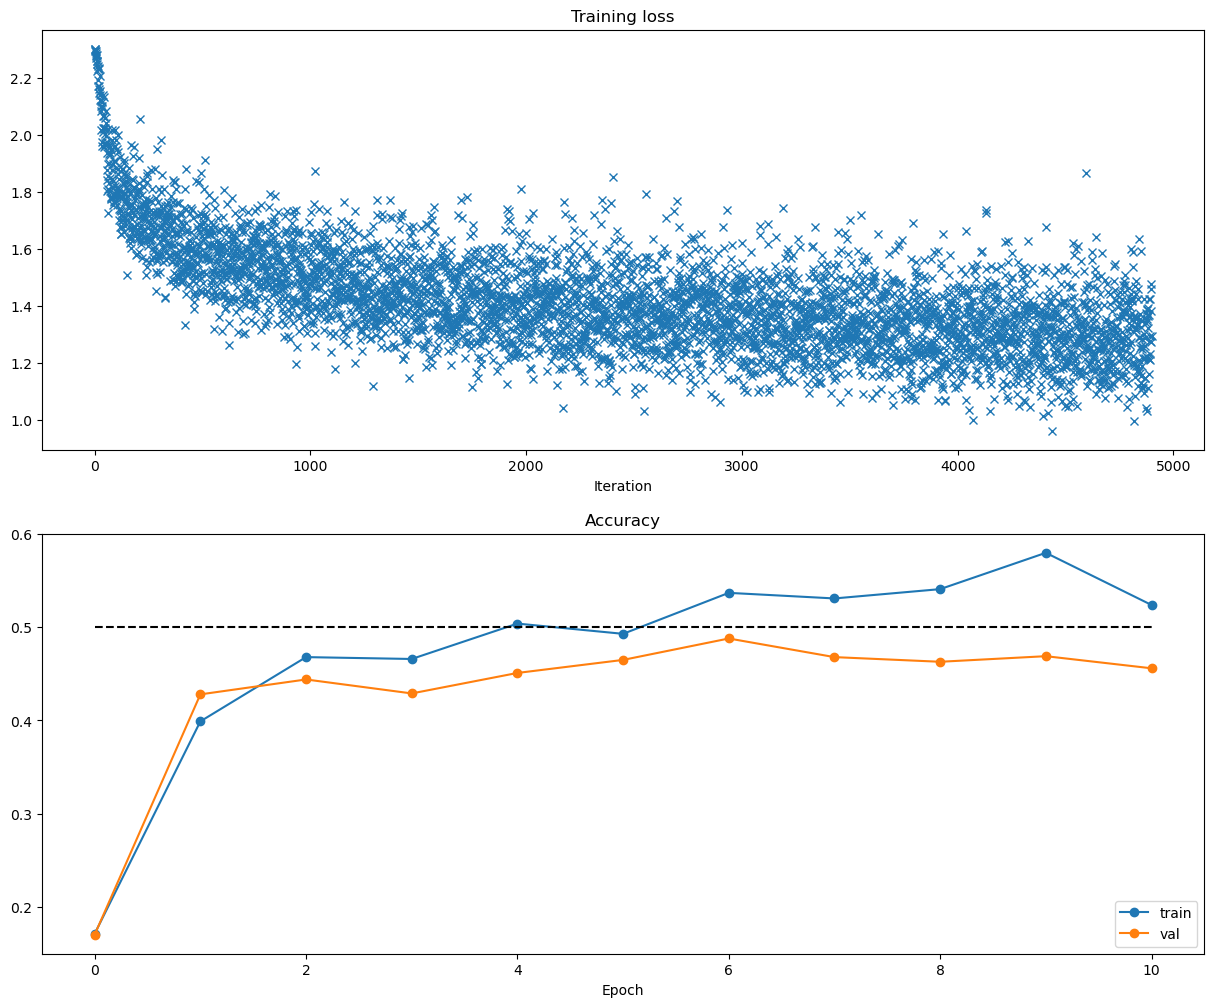

In [111]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'x')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Tune hyperparameters

In [ ]:
best_model = None

results = {}
input_size = 32 * 32 * 3
num_classes = 10

best_val = -1   # The highest validation accuracy that we have seen so far.

learning_rates = np.linspace(1e-4, 1e-3, 3)
regularization_strengths = np.geomspace(1e-6, 1e-2, 5)
hidden_sizes = np.linspace(100, 250, 3).astype(int)

for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        for hidden_size in hidden_sizes:

        model = TwoLayerNet(input_size, hidden_size, num_classes, reg = regularization_strength)
        solver = Solver(model, data, optim_config={'learning_rate': learning_rate}, verbose=False)
        solver.train()

        results[(learning_rate, regularization_strength, hidden_size)] = solver.best_val_acc

        if results[(learning_rate, regularization_strength, hidden_size)] > best_val:
            best_val = results[(learning_rate, regularization_strength, hidden_size)]
            best_model = model
      
        print(f"learning_rate = {learning_rate}, regularization_strength = {regularization_strength}, hidden_size = {hidden_size}")

        #visualize training loss and train / val accuracy
        plt.subplot(2, 1, 1)
        plt.title('Training loss')
        plt.plot(solver.loss_history, 'o')
        plt.xlabel('Iteration')

        plt.subplot(2, 1, 2)
        plt.title('Accuracy')
        plt.plot(solver.train_acc_history, '-o', label='train')
        plt.plot(solver.val_acc_history, '-o', label='val')
        plt.plot([0.5] * len(solver.val_acc_history), 'k--')
        plt.xlabel('Epoch')
        plt.legend(loc='lower right')
        plt.gcf().set_size_inches(15, 12)
        plt.show()

# Print out results.
for learning_rate, regularization_strength, hidden_size in sorted(results):
    val_accuracy = results[(learning_rate, regularization_strength, hidden_size)]
    print('learning_rate %e reg %e hidden_size %e val accuracy: %f' % (learning_rate, regularization_strength, hidden_size, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
for key, value in results.items():
    if value == best_val:
        print(key)

# Test model

In [69]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.537


In [70]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.523
